In [31]:
import numpy as np 
import pandas as pd 
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

In [3]:
filename="/Users/rishikabethi/Desktop/UrbanSound/archive/fold7/171165-9-0-70.wav"

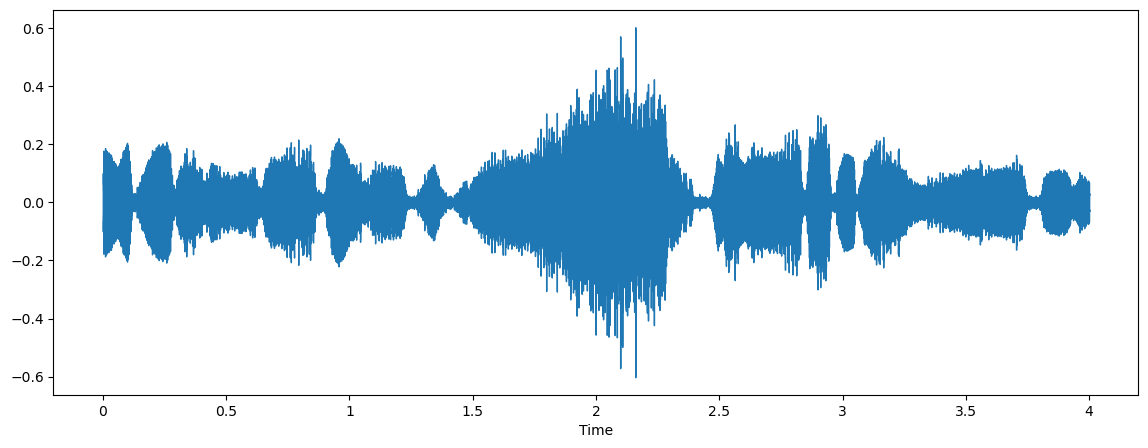

In [4]:
plt.figure(figsize=(14,5))
data, sample_rate= librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

In [5]:
data.size

88200

In [6]:
import pandas as pd
metadata= pd.read_csv("/Users/rishikabethi/Desktop/UrbanSound/UrbanSound8K.csv")

In [7]:
metadata.tail()

,slice_file_name,fsID,start,end,salience,fold,classID,class
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn
8731,99812-1-6-0.wav,99812,332.289233,334.821332,2,7,1,car_horn


In [8]:
metadata["class"].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

In [9]:
mfccs=librosa.feature.mfcc(y=data,sr=sample_rate,n_mfcc=40)

In [10]:
mfccs.shape

(40, 173)

In [11]:
mfccs

array([[-220.84264  , -219.03891  , -243.42828  , ..., -276.48798  ,
        -281.19586  , -272.0517   ],
       [ 126.20998  ,  102.7912   ,   71.198555 , ...,  142.80528  ,
         135.08359  ,  124.093414 ],
       [ -51.84884  ,  -50.096554 ,  -32.93839  , ...,  -46.785797 ,
         -39.64412  ,  -34.382126 ],
       ...,
       [ -11.391317 ,  -18.721115 ,  -28.624146 , ...,   -1.009692 ,
           4.450017 ,    5.8232155],
       [  -2.613771 ,   -4.105002 ,   -5.9451914, ...,  -10.987787 ,
          -7.852782 ,   -7.042756 ],
       [   6.5034413,    9.8473   ,   17.597748 , ...,   -7.416439 ,
         -13.203119 ,  -12.973476 ]], dtype=float32)

In [12]:
import os
audio_dataset_path="/Users/rishikabethi/Desktop/UrbanSound/archive"

In [13]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features   

In [14]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3554it [01:41, 41.93it/s]/Users/rishikabethi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8325it [12:18,  9.37it/s]/Users/rishikabethi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
8327it [12:18, 10.11it/s]/Users/rishikabethi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [13:23, 10.86it/s]


In [15]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-211.93698, 62.58121, -122.813156, -60.745293...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578075, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690277,...",children_playing


In [16]:
X=np.array(extracted_features_df["feature"].tolist())
y=np.array(extracted_features_df["class"].tolist())

In [17]:
X.shape

(8732, 40)

In [18]:
y.shape

(8732,)

In [19]:
y=np.array(pd.get_dummies(y))

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [21]:
X_train.shape

(5937, 40)

In [22]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Activation,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [23]:
model = Sequential()
model.add(Dense(100,input_shape=(40,)))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(200))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(100))
model.add(Activation("relu"))
model.add(Dropout(0.2))
          
model.add(Dense(10))
model.add(Activation("softmax"))

Metal device set to: Apple M1


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [25]:
model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer="adam")

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_valid, y_valid), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100


2023-07-11 12:32:14.475688: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


186/186 [==============================] - ETA: 0s - loss: 3.9225 - accuracy: 0.1686
Epoch 1: val_loss improved from inf to 2.18742, saving model to saved_models/audio_classification.hdf5
186/186 [==============================] - 9s 27ms/step - loss: 3.9225 - accuracy: 0.1686 - val_loss: 2.1874 - val_accuracy: 0.2271
Epoch 2/100
184/186 [============================>.] - ETA: 0s - loss: 2.0833 - accuracy: 0.2451
Epoch 2: val_loss improved from 2.18742 to 1.92363, saving model to saved_models/audio_classification.hdf5
186/186 [==============================] - 4s 23ms/step - loss: 2.0835 - accuracy: 0.2459 - val_loss: 1.9236 - val_accuracy: 0.3101
Epoch 3/100
185/186 [============================>.] - ETA: 0s - loss: 1.9195 - accuracy: 0.2954
Epoch 3: val_loss improved from 1.92363 to 1.82893, saving model to saved_models/audio_classification.hdf5
186/186 [==============================] - 5s 27ms/step - loss: 1.9194 - accuracy: 0.2956 - val_loss: 1.8289 - val_accuracy: 0.3158
Epoch 4/

186/186 [==============================] - 5s 25ms/step - loss: 0.5908 - accuracy: 0.7943 - val_loss: 0.6261 - val_accuracy: 0.7968
Epoch 26/100
184/186 [============================>.] - ETA: 0s - loss: 0.5630 - accuracy: 0.8035
Epoch 26: val_loss improved from 0.62612 to 0.58202, saving model to saved_models/audio_classification.hdf5
186/186 [==============================] - 4s 23ms/step - loss: 0.5620 - accuracy: 0.8036 - val_loss: 0.5820 - val_accuracy: 0.8244
Epoch 27/100
184/186 [============================>.] - ETA: 0s - loss: 0.5486 - accuracy: 0.8072
Epoch 27: val_loss improved from 0.58202 to 0.57386, saving model to saved_models/audio_classification.hdf5
186/186 [==============================] - 4s 23ms/step - loss: 0.5487 - accuracy: 0.8071 - val_loss: 0.5739 - val_accuracy: 0.8139
Epoch 28/100
184/186 [============================>.] - ETA: 0s - loss: 0.5368 - accuracy: 0.8167
Epoch 28: val_loss improved from 0.57386 to 0.56660, saving model to saved_models/audio_classi

Epoch 53/100
184/186 [============================>.] - ETA: 0s - loss: 0.2934 - accuracy: 0.9005
Epoch 53: val_loss improved from 0.42129 to 0.41813, saving model to saved_models/audio_classification.hdf5
186/186 [==============================] - 5s 26ms/step - loss: 0.2932 - accuracy: 0.9006 - val_loss: 0.4181 - val_accuracy: 0.8760
Epoch 54/100
184/186 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8983
Epoch 54: val_loss improved from 0.41813 to 0.41182, saving model to saved_models/audio_classification.hdf5
186/186 [==============================] - 5s 26ms/step - loss: 0.2981 - accuracy: 0.8979 - val_loss: 0.4118 - val_accuracy: 0.8721
Epoch 55/100
186/186 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.9038
Epoch 55: val_loss did not improve from 0.41182
186/186 [==============================] - 4s 24ms/step - loss: 0.2766 - accuracy: 0.9038 - val_loss: 0.4470 - val_accuracy: 0.8750
Epoch 56/100
184/186 [========================

186/186 [==============================] - 4s 23ms/step - loss: 0.1897 - accuracy: 0.9345 - val_loss: 0.4111 - val_accuracy: 0.8836
Epoch 82/100
184/186 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9293
Epoch 82: val_loss did not improve from 0.37880
186/186 [==============================] - 4s 23ms/step - loss: 0.1968 - accuracy: 0.9296 - val_loss: 0.4223 - val_accuracy: 0.8950
Epoch 83/100
186/186 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9314
Epoch 83: val_loss did not improve from 0.37880
186/186 [==============================] - 4s 23ms/step - loss: 0.2004 - accuracy: 0.9314 - val_loss: 0.4338 - val_accuracy: 0.8788
Epoch 84/100
184/186 [============================>.] - ETA: 0s - loss: 0.2057 - accuracy: 0.9285
Epoch 84: val_loss did not improve from 0.37880
186/186 [==============================] - 4s 23ms/step - loss: 0.2056 - accuracy: 0.9286 - val_loss: 0.4001 - val_accuracy: 0.8931
Epoch 85/100
184/186 [============

In [29]:
y_pred=model.predict(X_test)

55/55 [==============================] - 1s 3ms/step


In [32]:
c_acc = tf.keras.metrics.CategoricalAccuracy()
c_acc.update_state(y_test,y_pred)
c_acc.result().numpy()

0.895249

In [33]:
auc = tf.keras.metrics.AUC()
auc.update_state(y_test,y_pred)
auc.result().numpy()

0.9836966

In [34]:
recall = tf.keras.metrics.Recall()
recall.update_state(y_test,y_pred)
recall.result().numpy()

0.88609046

In [35]:
precision = tf.keras.metrics.Precision()
precision.update_state(y_test,y_pred)
precision.result().numpy()

0.9063232

In [28]:
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9838302135467529
Testing Accuracy:  0.8952490091323853


In [30]:
model.save("urban_sound")

In [31]:
from scipy.fftpack import fft, dct
spectrum=np.abs(np.fft.rfft([0.01675954]))
mel_filterbank = librosa.filters.mel(22050, 2048, n_mels=128, fmin=0, fmax=8000)
mel_spectrum = mel_filterbank.dot(spectrum)

# convert to dB
mel_spectrum = librosa.power_to_db(mel_spectrum)

# apply DCT to obtain MFCCs
mfcc = dct(mel_spectrum, type=2, axis=0, norm='ortho')